In [41]:
import iris
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import glob
import os
import numpy as np
import iris.coord_categorisation
import pandas as pd
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec

In [42]:
yearsec=60.0*60.0-24.0

In [110]:
'''
Input should be:
Temperature in K
S in PSU (I think)
DIC and ALK in MOL? values about 2.0
'''

'''
NOTE - this is currently designed to work with a single time-interval (i.e. cube without a time dimension)
'''

import numpy as np
import numpy.ma as ma
import scipy.stats
import keyword
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning)

print'  ops= 0 ;  output is iteration count'
print'       1 ;            pCO2'
print'       2 ;            pH'
print'       3 ;            [H2CO3]'
print'       4 ;            [HCO3]'
print'       5 ;            [CO3]'
print'       6 ;            satn [co3] : calcite'
print'       7 ;            saturation state: calcite'
print'       8 ;            satn [CO3] : aragonite'
print'       9 ;            saturation state: aragonite'
print'       10;            Ravelle factor (DIC) calculated from Egleston et al. 2010'
print'       11;            Alkalinity buffer factor calculated from Egleston et al. 2010'

print 'inputs: op_swtch,mdi,T,S,TCO2,TALK'

#Supply these as .data (arrays)
#salinity needs to be converted into psu *1000+35
#TCO2 and TALK must be in mol/kg /(1026.*1000.)
#the ones below here are not needed


def pressure_fun(a,b,c,d,e,T):
    del_vol = np.ones(T.shape, dtype='f')
    del_com = np.ones(T.shape, dtype='f') 
    pf = np.ones(T.shape, dtype='f')
    del_vol = a + b *T + c * np.power(T,2.0)
    del_com = 1.0e-3*( d + e*T )
    pf = np.exp( ( 0.5*del_com*Pr   - del_vol )*Pr / ( 83.131*TK ) )
    return pf

def carbiter(T, TCO2, TALK, TB, msk, tol, mxiter, K1, K2, KB, KW):
    aH = np.empty_like(T, dtype='f')
    aH.fill(1.0e-8)
    count = np.zeros_like(T)
    tol_swtch = np.zeros_like(T)
#MB -
#    AB = np.ones(T.shape)
#    AC = np.ones(T.shape)
#    AW = np.ones(T.shape)
    
    #MB+
    TBKB = TB * KB
    K2_K1x4 = 4.0 * K2 / K1
    K2_2 = 0.5 * K1
    #
    
    iter = 0
    test = 2.0
    while test > 0.5 and iter < mxiter:
        # Compute alkalinity guesses for Boron, Silicon, Phosphorus and Water
        #MB- AB = TB * KB / (aH + KB)
        #AB = TBKB / (aH + KB)
        AB = np.divide(TBKB,(aH + KB))
        #  ASi = TSi*KSi/( aH $
        #    + KSi )
        #  AP = TP*( 1.0/( 1.0 + KP2/aH $
        #    + KP2*KP3/(aH^2.0) ) + 2.0/( 1.0 $
        #    + aH/KP2 + KP3/aH ) $
        #    + 3.0/( 1.0 + aH/KP3 $
        #    + (aH^2.0)/(KP2*KP3) ) )
        AW = (KW / aH) - aH
        # using the guessed alkalinities and total alkalinity, calculate the
        # alkalinity due to carbon
        #  AC = TALK - ( AB + ASi $
        #    + AP + AW )
        AC = TALK - (AB + AW)
        # and recalculate aH with the new As
        #MB+
        TCO2_AC = TCO2 - AC
        #
        old_aH = np.copy(aH)
        #MB- aH = (0.5 * K1 / AC) * ((TCO2 - AC) + np.sqrt((TCO2 - AC) * (TCO2 - AC) + 4.0 * (AC * K2 / K1) * (2.0 * TCO2 - AC)))
        temp = TCO2_AC*TCO2_AC + (AC * K2_K1x4) * (2.0 * TCO2 - AC)
        aH = (K2_2 / AC) * (TCO2_AC + np.sqrt(temp))
        tol_swtch = abs((aH - old_aH) / old_aH) > tol
        count = count + tol_swtch
        test = np.sum(tol_swtch)
        iter += 1
        
    #aH[~msk] = 1.0
    #count[~msk] = 0
    return AC, AW, AB, aH, count


def carbchem_revelle(op_swtch,mdi,T_cube,S_cube,TCO2_cube,TALK_cube,Pr=0.0,TB=0.0,Ni=100.0,Tl=1.0e-5):
# This function calculates the inorganic carbon chemistry balance
# according to the method of Peng et al 1987
# The parameters are set in the first few lines

#salinity needs to be converted into psu
#TCO2 and TALK must be in mol/kg
#the ones below here are not needed

# This procedure calculates the inorganic carbon chemistry balance
# according to the method of Peng et al 1987
# The parameters are set in the first few lines
#
#  ops= 0 ;  output is iteration count
#       1 ;            pCO2
#       2 ;            pH
#       3 ;            [H2CO3]
#       4 ;            [HCO3]
#       5 ;            [CO3]
#       6 ;            satn [co3] : calcite
#       7 ;            saturation state: calcite
#       8 ;            satn [CO3] : aragonite
#       9 ;            saturation state: aragonite
#	10;            Ravelle factor (DIC) calculated from Egleston et al. 2010
#	11;            Alkalinity buffer factor calculated from Egleston et al. 2010

    #make sure grids are same size
    #make sure rthey years are the same
    #extarct the data from the cubes
    
# from iris import *
# from iris.analysis import *
# import iris.analysis
# from numpy import *
# from matplotlib.pyplot import *
# from scipy.stats.mstats import *
# import iris.plot as iplt
# import seawater
# import numpy
# import iris.quickplot as quickplot
# import iris.analysis.stats as istats
# temp = iris.load_cube('/home/ph290/tmp/hadgem2es_potential_temperature_historical_regridded.nc').extract(Constraint(depth = 0))
# sal = iris.load_cube('/home/ph290/tmp/hadgem2es_salinity_historical_regridded.nc').extract(Constraint(depth = 0))
# carb = iris.load_cube('/home/ph290/tmp/hadgem2es_dissolved_inorganic_carbon_historical_regridded.nc').extract(Constraint(depth = 0))
# alk = iris.load_cube('/home/ph290/tmp/hadgem2es_total_alkalinity_historical_regridded.nc').extract(Constraint(depth = 0))
# import carbchem
# co2 = carbchem.carbchem(1,temp.data.fill_value,temp,sal,carb,alk)
# T_cube = temp
# S_cube = sal
# TCO2_cube = carb
# TALK_cube = alk  
# mdi = temp.data.fill_value
	
    t_lat = np.size(T_cube.coord('latitude').points)    
    s_lat = np.size(S_cube.coord('latitude').points)
    c_lat = np.size(TCO2_cube.coord('latitude').points)
    a_lat = np.size(TALK_cube.coord('latitude').points)
    lat_test = t_lat == s_lat == c_lat == a_lat

    t_lon = np.size(T_cube.coord('longitude').points) 
    s_lon = np.size(S_cube.coord('longitude').points)
    c_lon = np.size(TCO2_cube.coord('longitude').points)
    a_lon = np.size(TALK_cube.coord('longitude').points)
    lon_test = t_lon == s_lon == c_lon == a_lon

    if lat_test and lon_test:

        output_cube = T_cube.copy()
        T_cube = T_cube
        T = T_cube.data.copy()
        S = S_cube.data.copy()
        TCO2_cube = TCO2_cube/1026.0
        # 		TCO2 = np.roll(ma.swapaxes(TCO2_cube.data.copy(),0,1),180)
        TCO2=TCO2_cube.data.copy()
        #NOTE - this is only required here 'cos glodap and WOA are differently ordered - not necessary for other stuff
        TALK_cube = TALK_cube/1026.0
        # 		TALK = np.roll(ma.swapaxes(TALK_cube.data.copy(),0,1),180)
        TALK = TALK_cube.data.copy()

        print np.mean(T)
        print np.mean(S)
        print np.mean(TCO2)
        print np.mean(TALK)
        print np.shape(T)
        print np.shape(S)
        print np.shape(TCO2)
        print np.shape(TALK)
        msk1=ma.masked_greater_equal(T,mdi-1.0,copy=True)
        msk2=ma.masked_greater_equal(S,mdi-1.0,copy=True)
        msk3=ma.masked_greater_equal(TCO2,mdi-1.0,copy=True)
        msk4=ma.masked_greater_equal(TALK,mdi-1.0,copy=True)

        msk=msk1.mask | msk2.mask | msk3.mask | msk4.mask

        T[msk]=np.nan
        S[msk]=np.nan
        TALK[msk]=np.nan
        TCO2[msk]=np.nan
        # 		plt.contourf(T)
        # 		plt.show()
        # 		plt.contourf(TCO2)
        # 		plt.show()

        # T = np.array([13.74232016,25.0])
        # S = np.array([33.74096661,35.0])
        # TCO2 = np.array([0.0019863,2.0e-3])
        # TALK = np.array([0.00226763,2.2e-3])
        # msk = ma.masked_greater_equal(T,mdi-1.0,copy=True)

        #create land-sea mask used by sea_msk.mask
        salmin = 1.0
        S2=np.copy(S)
        S2[np.abs(S) < salmin]=salmin

        tol = Tl
        mxiter = Ni

        op_fld = np.empty(T.shape)
        op_fld.fill(np.NAN)

        #    TB = np.ones(T.shape)
        #    TB = 4.106e-4*S2/35.0
        TB = np.empty_like(T)
        TB = np.multiply(S2,4.106e-4/35.0, TB)
        # this boron is from Peng

        #convert to Kelvin
        TK=np.copy(T[:])
        TK += +273.15

        alpha_s = np.ones(T.shape)
        alpha_s = np.exp( ( -60.2409 + 9345.17/TK  + 23.3585*np.log(TK/100.0) )  + ( 0.023517 - 0.023656*(TK/100.0) + 0.0047036*np.power((TK/100.0),2.0) )*S )

        K1 = np.ones(T.shape)
        K1 = np.exp( ( -2307.1266/TK + 2.83655  - 1.5529413*np.log(TK) ) - ( 4.0484/TK + 0.20760841 )*np.sqrt(S) + 0.08468345*S - 0.00654208*np.power(S,1.5) + np.log( 1.0 - 0.001005*S ) )

        a = np.array([-25.50,-15.82,-29.48,-25.60,-48.76,-46.0])
        b = np.array([0.1271,0.0219,0.2324,0.5304,0.5304])
        c = np.array([0.0,0.0,0.0026080,0.0036246,0.0,0.0])
        d = np.array([-3.08,1.13,(-2.84e-3)/(1.0e-3),-5.13,-11.76,-11.76])
        e = np.array([0.0877,0.1475,0.0,0.0794,0.3692,0.3692])

        if keyword.iskeyword(Pr):
            instance = 0
            pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
            K1 = K1*pf

        K2 = np.ones(T.shape)
        K2 = np.exp( ( -3351.6106/TK - 9.226508 - 0.2005743*np.log(TK) ) - ( 23.9722/TK + 0.106901773 )*np.power(S,0.5) + 0.1130822*S - 0.00846934*np.power(S,1.5) + np.log( 1.0 - 0.001005*S ) )

        if keyword.iskeyword(Pr):
            instance = 1
            pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
            K2 = K2*pf

        KB = np.ones(T.shape)
        KB = np.exp( ( -8966.90 - 2890.53*np.power(S,0.5) - 77.942*S + 1.728*np.power(S,1.5)- 0.0996*np.power(S,2.0) )/TK + ( 148.0248 + 137.1942*np.power(S,0.5) + 1.62142*S ) - ( 24.4344 + 25.085*np.power(S,0.5) + 0.2474*S )*np.log(TK) + 0.053105*(np.power(S,0.5))*TK )

        if keyword.iskeyword(Pr):
            instance = 2
            pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
            KB = KB*pf

        KW = np.ones(T.shape)
        KW = np.exp( ( -13847.26/TK + 148.96502 - 23.6521*np.log(TK) ) + ( 118.67/TK - 5.977 + 1.0495*np.log(TK) )*np.power(S,0.5) - 0.01615*S )

        if keyword.iskeyword(Pr):
            instance = 3
            pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
            KW = KW*pf

        if ( op_swtch >= 6 or op_swtch <= 9 ):
            ca_conc = np.ones(T.shape)
            ca_conc = 0.01028*S2/35.0

        if ( op_swtch == 6 or op_swtch == 7 ):
            K_SP_C = np.ones(T.shape)
            K_SP_C = np.power(10.0,( ( -171.9065 - 0.077993*TK + 2839.319/TK + 71.595*np.log10(TK) ) + ( -0.77712 + 0.0028426*TK + 178.34/TK )*np.power(S,0.5) - 0.07711*S+ 0.0041249*np.power(S,1.5) ))
            if keyword.iskeyword(Pr):
                instance = 4
                pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
                K_SP_C = K_SP_C*pf


        if ( op_swtch == 8 or op_swtch == 9 ):
            K_SP_A = np.ones(T.shape)
            K_SP_A = np.power(10,( ( -171.945 - 0.077993*TK + 2903.293/TK + 71.595*np.log10(TK) ) + ( -0.068393 + 0.0017276*TK + 88.135/TK )*np.power(S,0.5) - 0.10018*S + 0.0059415*np.power(S,1.5) ))
            if keyword.iskeyword(Pr):
                instance = 5
                pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
                K_SP_A = K_SP_A*pf


        # Get first estimate for H+ concentration.

        AC, AW, AB, aH, count = carbiter(T, TCO2, TALK, TB, msk, tol, mxiter, K1, K2, KB, KW)

        # 		plt.contourf(aH)
        # 		plt.show()
        # 		plt.contourf(AC)
        # 		plt.show()
        # 		plt.contourf(AW)
        # 		plt.show()
        # 		plt.contourf(aH)
        # 		plt.show()

        # now we have aH we can calculate...
        denom = np.zeros(T.shape)
        H2CO3 = np.zeros(T.shape)
        HCO3 = np.zeros(T.shape)
        CO3 = np.zeros(T.shape)
        pH = np.zeros(T.shape)
        pCO2 = np.zeros(T.shape)
        if ( op_swtch == 6 or op_swtch == 7 ):
            sat_CO3_C = np.zeros(T.shape)
        if ( op_swtch == 7 ):
            sat_stat_C = np.zeros(T.shape)
        if ( op_swtch == 8 or op_swtch == 9 ):
            sat_CO3_A = np.zeros(T.shape)
        if ( op_swtch == 9 ):
            sat_stat_A = np.zeros(T.shape)

        denom = np.power(aH,2.0) + K1*aH + K1*K2
        H2CO3 = TCO2*np.power(aH,2.0)/denom
        HCO3 = TCO2*K1*aH/denom
        CO3 = TCO2*K1*K2/denom
        # 		plt.contourf(K1)
        # 		plt.show()
        # 		plt.contourf(aH) -no
        # 		plt.show()
        # 		plt.contourf(denom) -no
        # 		plt.show()

        pH = -np.log10(aH)
        pCO2 = H2CO3/alpha_s

        if ( op_swtch == 6 or op_swtch == 7 ):
            sat_CO3_C = K_SP_C/ca_conc
            if ( op_swtch == 7 ):
                sat_stat_C = CO3/sat_CO3_C

        if ( op_swtch == 8 or op_swtch == 9 ):
            sat_CO3_A = K_SP_A/ca_conc
            if ( op_swtch == 9 ):
                sat_stat_A = CO3/sat_CO3_A

        TALKc=+HCO3+2*(CO3)
        var1=HCO3
        DIC_buffer=HCO3
        ALK_buffer=HCO3

        var1=HCO3+4*(CO3)+((aH*AB)/(KB+aH))-AW

        DIC_buffer=TCO2-((TALKc*TALKc)/var1)

        ALK_buffer=((TALKc*TALKc)-TCO2*var1)/TALKc

        output_cube = output_cube*0.0+np.nan
        if ( op_swtch == 0 ):
            op_fld = np.zeros(T.shape)
            op_fld = count
        elif ( op_swtch == 1 ):
            print np.mean(pCO2)
            output_cube.data = pCO2*1.0e6
            output_cube.standard_name = 'surface_partial_pressure_of_carbon_dioxide_in_sea_water'
            output_cube.long_name = 'CO2 concentration'
            output_cube.units = 'uatm'
        elif ( op_swtch == 2 ):
            output_cube.data = pH
            output_cube.standard_name = 'sea_water_ph_reported_on_total_scale'
            output_cube.long_name = 'pH'
            output_cube.units = '1'
        elif ( op_swtch == 3 ):
            output_cube.data = H2CO3
        elif ( op_swtch == 4 ):
            output_cube.data = HCO3
        elif ( op_swtch == 5 ):
            output_cube.data = CO3
        elif ( op_swtch == 6 ):
            output_cube.data = sat_CO3_C
        elif ( op_swtch == 7 ):
            output_cube.data = sat_stat_C
        elif ( op_swtch == 8 ):
            output_cube.data = sat_CO3_A
        elif ( op_swtch == 9 ):
            output_cube.data = sat_stat_A
        elif ( op_swtch == 10 ):
            output_cube.data = TCO2/DIC_buffer
        elif ( op_swtch == 11 ):
            output_cube.data = ALK_buffer*1000.0

        return output_cube


'''
test-data
'''

# def main():
# mdi=-999.0
# sizing=(500,500)
# T = np.empty(sizing)
# S = np.empty(sizing)
# TCO2 = np.empty(sizing)
# TALK = np.empty(sizing)
# T.fill(10.0)
# S.fill(35.0)
# TCO2.fill(0.0020)
# TALK.fill(0.0022)
# T[0,0]=mdi
# S[2,3]=mdi
# S[0,0]=0.5
# TALK[2,3]=mdi
# TCO2[2,3]=mdi
    
#     print carbchem(1,mdi,T,S,TCO2,TALK)

# import cProfile
# if __name__ == '__main__':
#     x=cProfile.run('main()')

#main()


  ops= 0 ;  output is iteration count
       1 ;            pCO2
       2 ;            pH
       3 ;            [H2CO3]
       4 ;            [HCO3]
       5 ;            [CO3]
       6 ;            satn [co3] : calcite
       7 ;            saturation state: calcite
       8 ;            satn [CO3] : aragonite
       9 ;            saturation state: aragonite
       10;            Ravelle factor (DIC) calculated from Egleston et al. 2010
       11;            Alkalinity buffer factor calculated from Egleston et al. 2010
inputs: op_swtch,mdi,T,S,TCO2,TALK


'\ntest-data\n'

In [95]:
def model_names(directory):
	files = glob.glob(directory+'/*.nc')
	models_tmp = []
	for file in files:
		statinfo = os.stat(file)
		if statinfo.st_size >= 1:
			models_tmp.append(file.split('/')[-1].split('_')[0])
			models = np.unique(models_tmp)
	return models

def mask_where_zero(cube):
    cube.data = np.ma.masked_array(cube.data)
    cube.data.fill_value= 9.99e9
    cube.data[np.where(cube.data == 0.0)] = 9.99e9
    cube.data = np.ma.masked_where(cube.data == 9.99e9,cube.data)
    return cube

def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
    return cube_region


def area_avg(cube):
#     first_dim = cube.coord(dimensions=1).long_name #latitude
#     second_dim = cube.coord(dimensions=2).long_name #longitude
    try:
        cube.coord('latitude').guess_bounds()
    except:
        print 'cube already has latitude bounds'
    try:
        cube.coord('longitude').guess_bounds()
    except:
        print 'cube already has longitude bounds'
    grid_areas = iris.analysis.cartography.area_weights(cube)
    area_avged_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.SUM, weights=grid_areas)
    return area_avged_cube

def avg_years(cube,start_yr,end_yr):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        print 'cube already has year dimension'
    loc = np.where((cube.coord('year').points >= start_yr) & (cube.coord('year').points <= end_yr))
    if len(loc[0]) > 0:
        return cube[loc].collapsed('time', iris.analysis.MEAN)
    else:
        cube=cube.collapsed('time', iris.analysis.MEAN)
        cube.data[:] = np.nan
        return cube

                   
def return_years(cube):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        print 'cube already has year dimension'
    return cube.coord('year').points




def populate_dict(data_dict,directory,models,variable,run,test_value):
    lon_west,lon_east,lat_south,lat_north=-80.0,10,0.0,80.0
    for model in models:
        go_ahead = True
        print model
        exists = os.path.isfile(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
        if exists:
            cube = iris.load_cube(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
#             cube = cube.collapsed(['depth'],iris.analysis.MEAN)
            iris.coord_categorisation.add_year(cube, 'time', name='year')
            cube = cube.aggregated_by('year', iris.analysis.MEAN)
            test = cube.collapsed(['latitude','longitude','time'],iris.analysis.MEAN)
            if test_value:
                if test.data > 0.6e-9:
                    go_ahead=False
            if go_ahead:
                first_dim = cube.coord(dimensions=1).long_name #latitude
                if first_dim == 'latitude':
    #                 cube.coord(dimensions=1).rename('latitude')
    #                 cube.coord(dimensions=2).rename('longitude')
                    cube = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
                    data_dict[run][variable][model] = {}
                    data_dict[run][variable][model]['timeseries'] = area_avg(cube)
                    data_dict[run][variable][model]['years'] = return_years(cube)
                    data_dict[run][variable][model]['first20'] = first_20_avg = avg_years(cube,2006,2026)
                    data_dict[run][variable][model]['last20'] = last_20_avg = avg_years(cube,2079,2099)
        else:
            print directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc does not exist'
    return data_dict

In [45]:
directory = '/data/BatCaveNAS/ph290/noc_talk/regridded/'



In [46]:
models = model_names(directory)
models = list(models)
models.remove('GFDL-ESM2M')
models.remove('CNRM-CM5')

data_dict = {}




In [47]:
variable = 'fgco2'
run = 'rcp85'
data_dict[run] = {}
data_dict[run][variable] = {}

In [48]:
data_dict = populate_dict(data_dict,directory,models,variable,run,True)

BNU-ESM
CESM1-BGC
cube already has year dimension
cube already has year dimension
cube already has year dimension
CMCC-CESM
cube already has year dimension
cube already has year dimension
cube already has year dimension
CanESM2
GFDL-ESM2G
/data/BatCaveNAS/ph290/noc_talk/regridded/GFDL-ESM2G_fgco2_rcp85_r1i1p1_regridded.nc does not exist
GISS-E2-H-CC
cube already has year dimension
cube already has year dimension
cube already has year dimension
GISS-E2-R-CC
cube already has year dimension
cube already has year dimension
cube already has year dimension
HadGEM2-CC
cube already has year dimension
cube already has year dimension
cube already has year dimension
HadGEM2-ES
cube already has year dimension
cube already has year dimension
cube already has year dimension
IPSL-CM5A-LR
cube already has year dimension
cube already has year dimension
cube already has year dimension
IPSL-CM5A-MR
cube already has year dimension
cube already has year dimension
cube already has year dimension
IPSL-CM5B-L

In [49]:
variable = 'fgco2'
run = 'rcp26'
data_dict[run] = {}
data_dict[run][variable] = {}
data_dict = populate_dict(data_dict,directory,models,variable,run,True)

BNU-ESM
CESM1-BGC
/data/BatCaveNAS/ph290/noc_talk/regridded/CESM1-BGC_fgco2_rcp26_r1i1p1_regridded.nc does not exist
CMCC-CESM
/data/BatCaveNAS/ph290/noc_talk/regridded/CMCC-CESM_fgco2_rcp26_r1i1p1_regridded.nc does not exist
CanESM2
cube already has year dimension
cube already has year dimension
cube already has year dimension
GFDL-ESM2G
/data/BatCaveNAS/ph290/noc_talk/regridded/GFDL-ESM2G_fgco2_rcp26_r1i1p1_regridded.nc does not exist
GISS-E2-H-CC
/data/BatCaveNAS/ph290/noc_talk/regridded/GISS-E2-H-CC_fgco2_rcp26_r1i1p1_regridded.nc does not exist
GISS-E2-R-CC
/data/BatCaveNAS/ph290/noc_talk/regridded/GISS-E2-R-CC_fgco2_rcp26_r1i1p1_regridded.nc does not exist
HadGEM2-CC
/data/BatCaveNAS/ph290/noc_talk/regridded/HadGEM2-CC_fgco2_rcp26_r1i1p1_regridded.nc does not exist
HadGEM2-ES
cube already has year dimension
cube already has year dimension
cube already has year dimension
IPSL-CM5A-LR
cube already has year dimension
cube already has year dimension
cube already has year dimension
IP

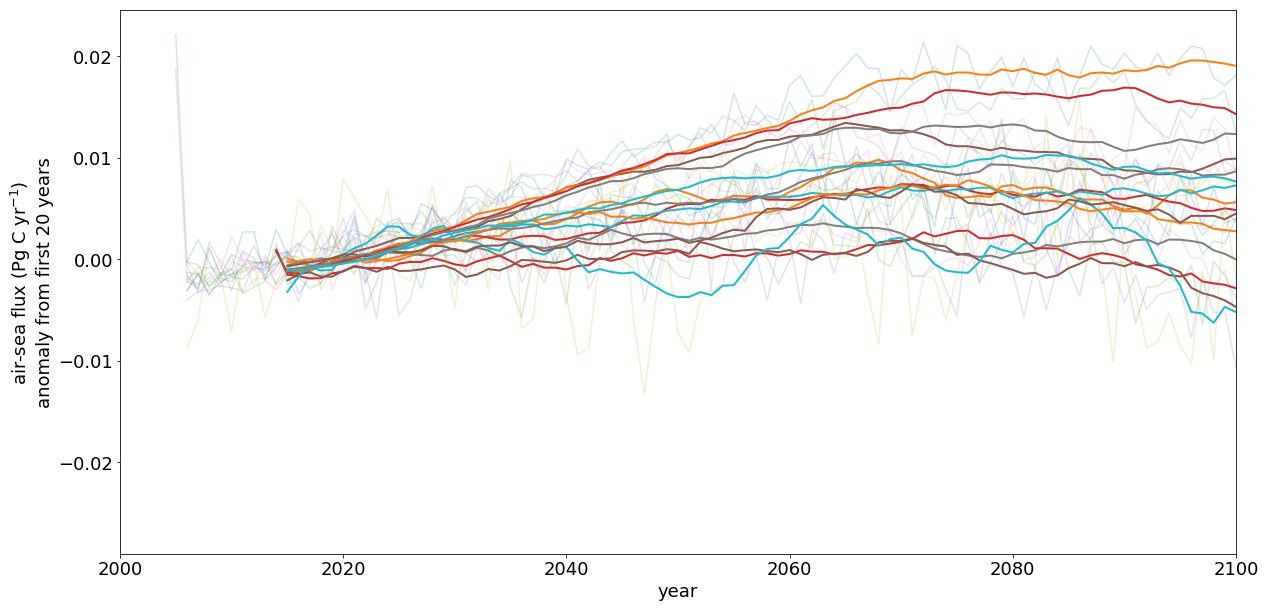

In [50]:
variable = 'fgco2'
run = 'rcp85'

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))
for model in list(data_dict[run][variable]):
    df = pd.DataFrame({'tmp':(data_dict[run][variable][model]['timeseries'].data*365.0*yearsec)/1.0e12})
    plt.plot(data_dict[run][variable][model]['years'],df.tmp-df.tmp[0:20].mean(),alpha=0.2,label=model)
    plt.plot(data_dict[run][variable][model]['years'],df.tmp.rolling(10).mean()-df.tmp[0:20].mean(),lw=2,label=model)

plt.xlim([2000,2100])
# plt.legend(loc=1)
plt.xlabel('year')
plt.ylabel('air-sea flux (Pg C yr$^{-1}$)\nanomaly from first 20 years')
plt.show()



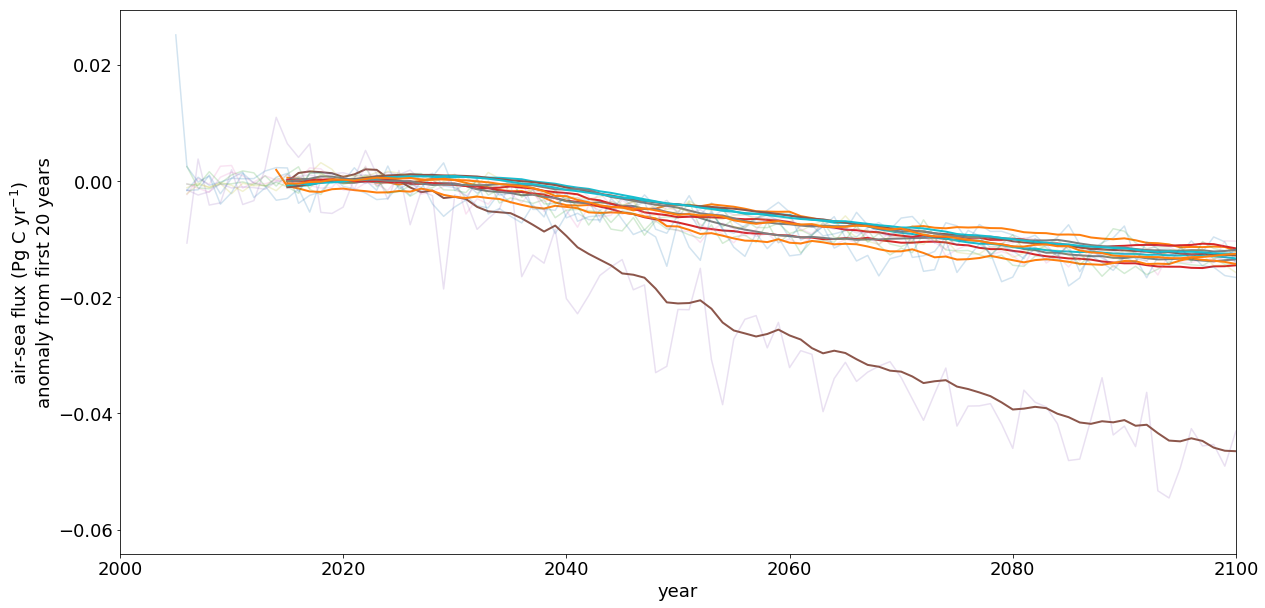

In [51]:
variable = 'fgco2'
run = 'rcp26'

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))
for model in list(data_dict[run][variable]):
    df = pd.DataFrame({'tmp':(data_dict[run][variable][model]['timeseries'].data*365.0*yearsec)/1.0e12})
    plt.plot(data_dict[run][variable][model]['years'],df.tmp-df.tmp[0:20].mean(),alpha=0.2,label=model)
    plt.plot(data_dict[run][variable][model]['years'],df.tmp.rolling(10).mean()-df.tmp[0:20].mean(),lw=2,label=model)

plt.xlim([2000,2100])
# plt.legend(loc=1)
plt.xlabel('year')
plt.ylabel('air-sea flux (Pg C yr$^{-1}$)\nanomaly from first 20 years')
plt.show()

In [52]:
def calculate_agreement(run_composites,agreement):
    # run_composites=run_composites[lag]
    composites_agreement = run_composites[0].copy()
    composites_agreement[:] = 0.0
    for i in range(np.shape(run_composites)[1]):
        for j in range(np.shape(run_composites)[2]):
            tmp1 = run_composites[:,i,j]
            a = np.float(len(np.where(tmp1 > 0.0)[0]))
            b = np.float(len(np.where(tmp1 < 0.0)[0]))
            ratio = np.max([a/len(tmp1),b/len(tmp1)])
            # if b > 0.0:
            #     ratio = (a / b)
            #     # print 'ratio ',ratio
            if ratio > agreement:
                composites_agreement[i,j] = np.NAN
            if run_composites[:,i,j].all() == 0.0:
            	composites_agreement[i,j] = np.NAN
    return composites_agreement

In [53]:
variable = 'fgco2'
run = 'rcp85'
models = list(data_dict[run][variable])
shape = np.shape(data_dict[run][variable][models[0]]['first20'])
first_period = np.zeros([len(data_dict[run][variable]),shape[0],shape[1]])
first_period[:] = np.nan
last_period=first_period.copy()
for i,model in enumerate(list(data_dict[run][variable])):
    first_period[i,:,:] = data_dict[run][variable][model]['first20'].data
    last_period[i,:,:] = data_dict[run][variable][model]['last20'].data


diff = last_period-first_period

diff_mean = np.mean(diff,axis=0)

tmp_cube = data_dict[run][variable][model]['first20']
tmp_cube.data = diff_mean
agreement = 0.66
agreement_map = calculate_agreement(diff,agreement)

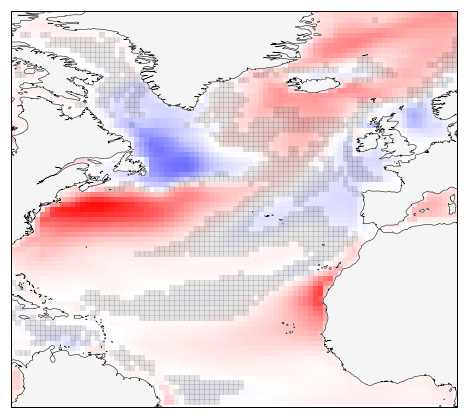

In [54]:
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
coast_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',facecolor='none')

my_projection = ccrs.PlateCarree()
my_extent = [-80.0,10,0.0,80.0]

plt.close('all')
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(10, 10)
ax1 = plt.subplot(gs[0:10,0:10],projection= my_projection)


ax1.set_extent(my_extent, crs=ccrs.PlateCarree())


lats1 = tmp_cube.coord('latitude').points
lons1 = tmp_cube.coord('longitude').points
data1 = tmp_cube.data


contour_result1 = ax1.pcolormesh(lons1, lats1, data1,vmin=-1.5E-9,vmax=1.5E-9,
			transform=ccrs.PlateCarree(),cmap='bwr')
contour_result2 = ax1.pcolormesh(lons1, lats1, agreement_map,
			transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=1,alpha=0.1)

ax1.add_feature(land_50m,facecolor='#F5F5F5')
ax1.add_feature(coast_50m,edgecolor='#000000',lw=0.5)



Multi model mean change in update last 20 years - first 20 yeats 
greyed is where fewer than 66% of models agree on the sign of change

In [55]:
models = model_names(directory)
models = list(models)
models.remove('GFDL-ESM2M')
models.remove('CNRM-CM5')
models.remove('MIROC-ESM-CHEM')
models.remove('GFDL-ESM2G')
models.remove('MIROC-ESM')
models.remove('inmcm4')

variable = 'talk'
run = 'rcp85'
data_dict[run][variable] = {}
data_dict = populate_dict(data_dict,directory,models,variable,run,False)

BNU-ESM
cube already has year dimension
cube already has year dimension
cube already has year dimension
CESM1-BGC
cube already has year dimension
cube already has year dimension
cube already has year dimension
CMCC-CESM
cube already has year dimension
cube already has year dimension
cube already has year dimension
CanESM2
cube already has year dimension
cube already has year dimension
cube already has year dimension
GISS-E2-H-CC
/data/BatCaveNAS/ph290/noc_talk/regridded/GISS-E2-H-CC_talk_rcp85_r1i1p1_regridded.nc does not exist
GISS-E2-R-CC
/data/BatCaveNAS/ph290/noc_talk/regridded/GISS-E2-R-CC_talk_rcp85_r1i1p1_regridded.nc does not exist
HadGEM2-CC
cube already has year dimension
cube already has year dimension
cube already has year dimension
HadGEM2-ES
cube already has year dimension
cube already has year dimension
cube already has year dimension
IPSL-CM5A-LR
cube already has year dimension
cube already has year dimension
cube already has year dimension
IPSL-CM5A-MR
cube already has

In [56]:
variable = 'dissic'
run = 'rcp85'
data_dict[run][variable] = {}
data_dict = populate_dict(data_dict,directory,models,variable,run,False)

BNU-ESM
cube already has year dimension
cube already has year dimension
cube already has year dimension
CESM1-BGC
cube already has year dimension
cube already has year dimension
cube already has year dimension
CMCC-CESM
cube already has year dimension
cube already has year dimension
cube already has year dimension
CanESM2
cube already has year dimension
cube already has year dimension
cube already has year dimension
GISS-E2-H-CC
cube already has year dimension
cube already has year dimension
cube already has year dimension
GISS-E2-R-CC
cube already has year dimension
cube already has year dimension
cube already has year dimension
HadGEM2-CC
cube already has year dimension
cube already has year dimension
cube already has year dimension
HadGEM2-ES
cube already has year dimension
cube already has year dimension
cube already has year dimension
IPSL-CM5A-LR
cube already has year dimension
cube already has year dimension
cube already has year dimension
IPSL-CM5A-MR
cube already has year dime

In [129]:
variable = 'tos'
run = 'rcp85'
data_dict[run][variable] = {}
data_dict = populate_dict(data_dict,directory,models,variable,run,False)

IPSL-CM5A-LR


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable u'areacello', referenced by netCDF variable u'tos'
  warnings.warn(message % (variable_name, nc_var_name))


cube already has year dimension
cube already has year dimension
cube already has year dimension
MPI-ESM-LR
cube already has year dimension
cube already has year dimension
cube already has year dimension
CanESM2
cube already has year dimension
cube already has year dimension
cube already has year dimension
GISS-E2-R-CC
cube already has year dimension
cube already has year dimension
cube already has year dimension
BNU-ESM
/data/BatCaveNAS/ph290/noc_talk/regridded/BNU-ESM_tos_rcp85_r1i1p1_regridded.nc does not exist
IPSL-CM5B-LR
cube already has year dimension
cube already has year dimension
cube already has year dimension
NorESM1-ME
cube already has year dimension
cube already has year dimension
cube already has year dimension
HadGEM2-ES
cube already has year dimension
cube already has year dimension
cube already has year dimension
HadGEM2-CC
cube already has year dimension
cube already has year dimension
cube already has year dimension
GISS-E2-H-CC
cube already has year dimension
cube a

In [133]:
variable = 'sos'
run = 'rcp85'
data_dict[run][variable] = {}
data_dict = populate_dict(data_dict,directory,models,variable,run,False)

IPSL-CM5A-LR


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable u'areacello', referenced by netCDF variable u'sos'
  warnings.warn(message % (variable_name, nc_var_name))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1935: UserWarning: Ignoring netCDF variable u'sos' invalid units u'psu'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))


cube already has year dimension
cube already has year dimension
cube already has year dimension
CESM1-BGC
cube already has year dimension
cube already has year dimension
cube already has year dimension
CanESM2
cube already has year dimension
cube already has year dimension
cube already has year dimension
GISS-E2-R-CC
cube already has year dimension
cube already has year dimension
cube already has year dimension
IPSL-CM5B-LR
cube already has year dimension
cube already has year dimension
cube already has year dimension
NorESM1-ME
cube already has year dimension
cube already has year dimension
cube already has year dimension
HadGEM2-ES
cube already has year dimension
cube already has year dimension
cube already has year dimension
HadGEM2-CC
cube already has year dimension
cube already has year dimension
cube already has year dimension
GISS-E2-H-CC
cube already has year dimension
cube already has year dimension
cube already has year dimension
CMCC-CESM
cube already has year dimension
cube

In [156]:
variable = 'talk'
run = 'rcp85'
models = list(data_dict[run][variable])
print models
shape = np.shape(data_dict[run][variable][models[0]]['first20'])
first_period = np.zeros([len(data_dict[run][variable]),shape[0],shape[1]])
first_period[:] = np.nan
last_period=first_period.copy()
for i,model in enumerate(list(data_dict[run][variable])):
    first_period[i,:,:] = data_dict[run][variable][model]['first20'].data
    last_period[i,:,:] = data_dict[run][variable][model]['last20'].data



first_period_mean = np.mean(first_period,axis=0)

tmp_cube_talk = data_dict[run][variable][model]['first20']
tmp_cube_talk.data = first_period_mean
tmp_cube_talk_2 = tmp_cube_talk.copy()
tmp_cube_talk_2.data = np.mean(last_period,axis=0)

['IPSL-CM5A-LR', 'MPI-ESM-LR', 'CanESM2', 'BNU-ESM', 'IPSL-CM5B-LR', 'NorESM1-ME', 'HadGEM2-ES', 'HadGEM2-CC', 'CMCC-CESM', 'MPI-ESM-MR', 'IPSL-CM5A-MR', 'CESM1-BGC']


In [157]:
variable = 'dissic'
run = 'rcp85'
models = list(data_dict[run][variable])
print models
shape = np.shape(data_dict[run][variable][models[0]]['first20'])
first_period = np.zeros([len(data_dict[run][variable]),shape[0],shape[1]])
first_period[:] = np.nan
last_period=first_period.copy()
for i,model in enumerate(list(data_dict[run][variable])):
    first_period[i,:,:] = data_dict[run][variable][model]['first20'].data
    last_period[i,:,:] = data_dict[run][variable][model]['last20'].data



first_period_mean = np.mean(first_period,axis=0)

tmp_cube_dissic = data_dict[run][variable][model]['first20']
tmp_cube_dissic.data = first_period_mean
tmp_cube_dissic_2 = tmp_cube_dissic.copy()
tmp_cube_dissic_2.data = np.mean(last_period,axis=0)

['IPSL-CM5A-LR', 'MPI-ESM-LR', 'CanESM2', 'GISS-E2-R-CC', 'BNU-ESM', 'IPSL-CM5B-LR', 'NorESM1-ME', 'HadGEM2-ES', 'HadGEM2-CC', 'GISS-E2-H-CC', 'CMCC-CESM', 'MPI-ESM-MR', 'IPSL-CM5A-MR', 'CESM1-BGC']


In [155]:
variable = 'tos'
run = 'rcp85'
models = list(data_dict[run][variable])
print models
shape = np.shape(data_dict[run][variable][models[0]]['first20'])
first_period = np.zeros([len(data_dict[run][variable]),shape[0],shape[1]])
first_period[:] = np.nan
last_period=first_period.copy()
for i,model in enumerate(list(data_dict[run][variable])):
    first_period[i,:,:] = data_dict[run][variable][model]['first20'].data
    last_period[i,:,:] = data_dict[run][variable][model]['last20'].data



first_period_mean = np.mean(first_period,axis=0)

tmp_cube_tos = data_dict[run][variable][model]['first20']
tmp_cube_tos.data = first_period_mean
tmp_cube_tos_2 = tmp_cube_tos.copy()
tmp_cube_tos_2.data = np.mean(last_period,axis=0)

['IPSL-CM5A-LR', 'CESM1-BGC', 'CanESM2', 'GISS-E2-R-CC', 'IPSL-CM5B-LR', 'NorESM1-ME', 'HadGEM2-ES', 'HadGEM2-CC', 'GISS-E2-H-CC', 'CMCC-CESM', 'MPI-ESM-MR', 'MPI-ESM-LR', 'IPSL-CM5A-MR']


In [154]:
variable = 'sos'
run = 'rcp85'
models = list(data_dict[run][variable])
print models
shape = np.shape(data_dict[run][variable][models[0]]['first20'])
first_period = np.zeros([len(data_dict[run][variable]),shape[0],shape[1]])
first_period[:] = np.nan
last_period=first_period.copy()
for i,model in enumerate(list(data_dict[run][variable])):
    first_period[i,:,:] = data_dict[run][variable][model]['first20'].data
    last_period[i,:,:] = data_dict[run][variable][model]['last20'].data



first_period_mean = np.mean(first_period,axis=0)

tmp_cube_sos = data_dict[run][variable][model]['first20']
tmp_cube_sos.data = first_period_mean
tmp_cube_sos_2 = tmp_cube_sos.copy()
tmp_cube_sos_2.data = np.mean(last_period,axis=0)

['IPSL-CM5A-LR', 'CanESM2', 'GISS-E2-R-CC', 'IPSL-CM5B-LR', 'NorESM1-ME', 'HadGEM2-ES', 'HadGEM2-CC', 'GISS-E2-H-CC', 'CMCC-CESM', 'MPI-ESM-MR', 'MPI-ESM-LR', 'IPSL-CM5A-MR', 'CESM1-BGC']


In [158]:
tmp_cube_talk = mask_where_zero(tmp_cube_talk)
tmp_cube_dissic = mask_where_zero(tmp_cube_dissic)
tmp_cube_tos = mask_where_zero(tmp_cube_tos)
tmp_cube_sos = mask_where_zero(tmp_cube_sos)

# revelle_factor = carbchem_revelle(10,9.99e9,(tmp_cube_talk *0.0)+15.0,(tmp_cube_talk *0.0)+35.0,tmp_cube_dissic,tmp_cube_talk)
revelle_factor = carbchem_revelle(10,9.99e9,tmp_cube_tos-273.15,tmp_cube_sos,tmp_cube_dissic,tmp_cube_talk)
revelle_factor_last = carbchem_revelle(10,9.99e9,tmp_cube_tos_2-273.15,tmp_cube_sos_2,tmp_cube_dissic_2,tmp_cube_talk_2)

212276856.12240842
212276966.35182908
-0.018492759284597076
-0.022731445072836053
(80, 91)
(80, 91)
(80, 91)
(80, 91)
-78.99137226651919
20.512713657434297
0.0013904336334287558
0.0014770610360316848
(80, 91)
(80, 91)
(80, 91)
(80, 91)


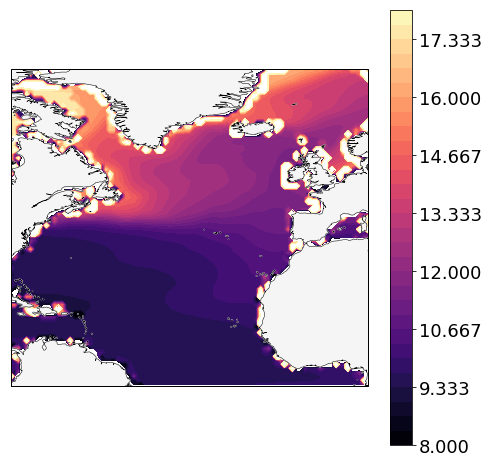

In [162]:

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(10, 10)
ax1 = plt.subplot(gs[0:10,0:10],projection= my_projection)


ax1.set_extent(my_extent, crs=ccrs.PlateCarree())


lats1 = revelle_factor.coord('latitude').points
lons1 = revelle_factor.coord('longitude').points
data1 = revelle_factor.data


contour_result1 = ax1.contourf(lons1, lats1, data1,np.linspace(8,18,31),
			transform=ccrs.PlateCarree(),cmap='magma')


ax1.add_feature(land_50m,facecolor='#F5F5F5')
ax1.add_feature(coast_50m,edgecolor='#000000',lw=0.5)
plt.colorbar(contour_result1)

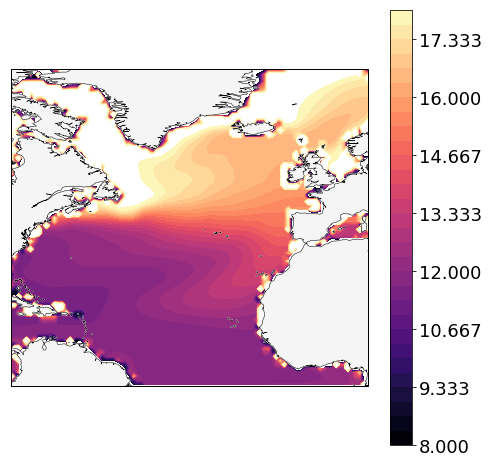

In [161]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(10, 10)
ax1 = plt.subplot(gs[0:10,0:10],projection= my_projection)


ax1.set_extent(my_extent, crs=ccrs.PlateCarree())


lats1 = revelle_factor_last.coord('latitude').points
lons1 = revelle_factor_last.coord('longitude').points
data1 = revelle_factor_last.data


contour_result1 = ax1.contourf(lons1, lats1, data1,np.linspace(8,18,31),
			transform=ccrs.PlateCarree(),cmap='magma')


ax1.add_feature(land_50m,facecolor='#F5F5F5')
ax1.add_feature(coast_50m,edgecolor='#000000',lw=0.5)
plt.colorbar(contour_result1)

In [ ]:
test